## Initial Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import zipfile

from google.colab import drive
from transformers import pipeline

In [2]:
# Mount GDrive
drive.mount("/content/drive")

# Unzip file (only for the first time we run this code)
# !unzip "/content/drive/Shareddrives/adv-ml-project/Data/kaggle_climate_reddit.zip" -d "/content/drive/Shareddrives/adv-ml-project/Data"

Mounted at /content/drive


### I. Load and Subset Data

In [3]:
# Load data (takes 2 mins to load `comments`)
data_path = "/content/drive/Shareddrives/adv-ml-project/Data/"
comments = pd.read_csv(data_path + "the-reddit-climate-change-dataset-comments.csv")
posts = pd.read_csv(data_path + "the-reddit-climate-change-dataset-posts.csv")

In [4]:
# We remove columns that we won't use in the analysis:
comments = comments[['subreddit.name','created_utc','body','sentiment']]
posts = posts[['subreddit.name','created_utc','title']]

In [5]:
# Define date
comments['date'] = pd.to_datetime(comments['created_utc'], unit='s')
posts['date'] = pd.to_datetime(posts['created_utc'], unit='s')

### II. Basic Exploratory Data Analysis

Some of the things that are worth checking are:

1. Variable description
2. Define timeframe for analysis
3. Check number of registers by period
4. Check number of subredits in data
5. Count number of tokens in each comment

### II.a Variable description

In [6]:
comments.describe(include='all')

<ipython-input-6-945818fc6bb2>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  comments.describe(include='all')


,subreddit.name,created_utc,body,sentiment,date
count,4600698,4.600698e+06,4600698,4.543567e+06,4600698
unique,30889,NaN,4485881,NaN,4536099
top,politics,NaN,Climate change,NaN,2020-08-28 11:50:28
freq,370018,NaN,9190,NaN,8
first,NaN,NaN,NaN,NaN,2010-01-01 00:34:07
last,NaN,NaN,NaN,NaN,2022-08-31 23:59:28
mean,NaN,1.560607e+09,NaN,-5.827452e-03,NaN
std,NaN,7.576261e+07,NaN,6.581439e-01,NaN
min,NaN,1.262306e+09,NaN,-1.000000e+00,NaN
25%,NaN,1.518140e+09,NaN,-6.369000e-01,NaN


A description of the `comments` df show that:
* There are 30889 subreddits
* There are apparently duplicates in the `body` column, but this is due to removed columns
* The dataset has 12 years of observations (2010-2022)

In [7]:
posts.describe(include='all')

<ipython-input-7-1619c487c582>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  posts.describe(include='all')


,subreddit.name,created_utc,title,date
count,620908,6.209080e+05,620908,620908
unique,23203,NaN,416654,615500
top,ecointernet,NaN,Climate Change,2018-01-26 14:30:14
freq,39994,NaN,763,15
first,NaN,NaN,NaN,2010-01-01 00:12:30
last,NaN,NaN,NaN,2022-08-31 23:57:17
mean,NaN,1.540695e+09,NaN,NaN
std,NaN,7.738068e+07,NaN,NaN
min,NaN,1.262305e+09,NaN,NaN
25%,NaN,1.497725e+09,NaN,NaN


### II.b Timeframe

### II.c Comments per period

We define two periods, `year_month` and `year`:

In [8]:
comments['year_month'] = comments['date'].dt.to_period('M')
comments['year'] = comments['date'].dt.to_period('Y')

In [9]:
num_obs_year_month = comments.groupby('year_month').agg({'body':'count'}).reset_index().rename(columns={'body':'cnt'})
num_obs_year = comments.groupby('year').agg({'body':'count'}).reset_index().rename(columns={'body':'cnt'})

In [10]:
num_obs_year_month.describe()

,cnt
count,152.000000
mean,30267.750000
std,29987.929909
min,825.000000
25%,4444.250000
50%,20023.500000
75%,52794.000000
max,125877.000000


In [11]:
num_obs_year.describe()

,cnt
count,13.000000
mean,353899.846154
std,326894.727886
min,16282.000000
25%,65170.000000
50%,314517.000000
75%,587174.000000
max,978413.000000


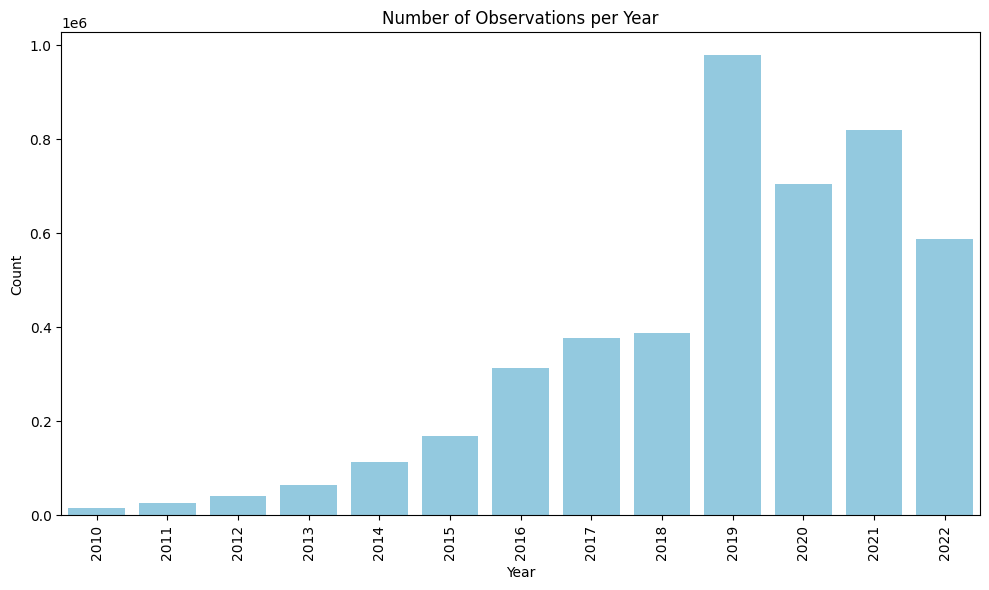

In [12]:
# Create the plot for year
plt.figure(figsize=(10, 6))
sns.barplot(data=num_obs_year, x='year', y='cnt', color='skyblue')

# Adjust the frequency of x-axis labels to show only a subset
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # Show a X number of intervals

#Customize
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Number of Observations per Year')

plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

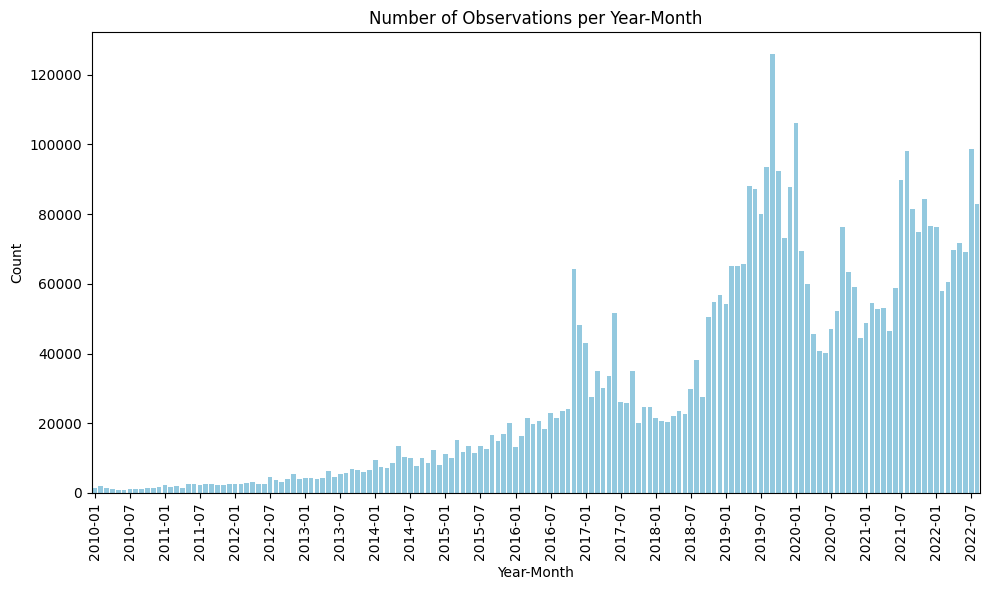

In [13]:
# Create the plot for year_month
num_obs_year_month['year_month'] = num_obs_year_month['year_month'].astype(str)
plt.figure(figsize=(10, 6))
sns.barplot(data=num_obs_year_month, x='year_month', y='cnt', color='skyblue')

# Adjust the frequency of x-axis labels to show only a subset
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(6))  # Show a X number of intervals

#Customize
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.title('Number of Observations per Year-Month')

plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

### III.d Number of subreddits

In [14]:
cnt_subreddits = comments.groupby(['subreddit.name']).agg({'body':'count'}).reset_index().rename(columns={'body':'cnt'}).sort_values('cnt', ascending=False)

In [15]:
cnt_subreddits['share_cnt'] = cnt_subreddits['cnt'] / cnt_subreddits['cnt'].sum()

In [1]:
cnt_subreddits.head(150)['share_cnt'].sum()

NameError: name 'cnt_subreddits' is not defined

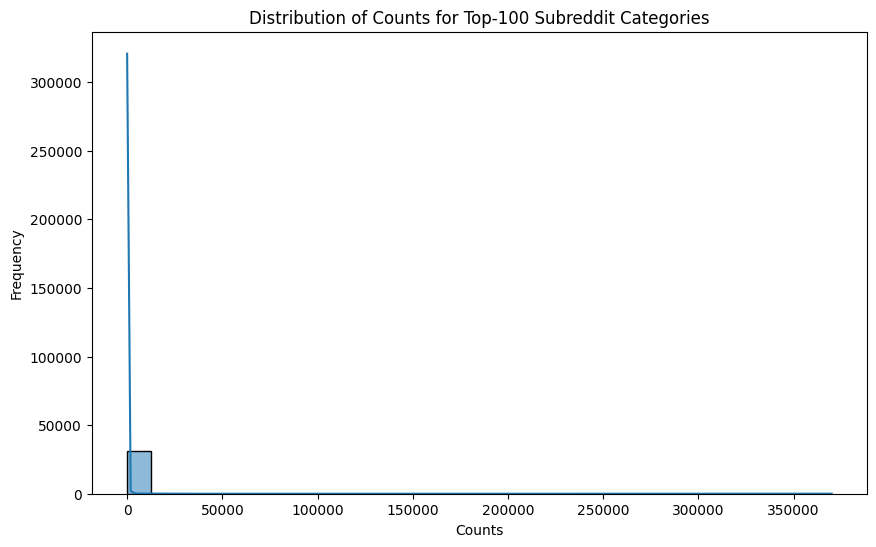

In [32]:
# Plot the histogram of top 100 subreddits
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.histplot(data=cnt_subreddits, x='cnt', bins=30, kde=True)

plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.title('Distribution of Counts for Top-100 Subreddit Categories')

plt.show()

As we can see from the plot, there are several subreddits that have few observations. We could define a number to reduce the dataset.

### III.e Length of sequences

In [18]:
comments['len_body'] = comments['body'].apply(len)

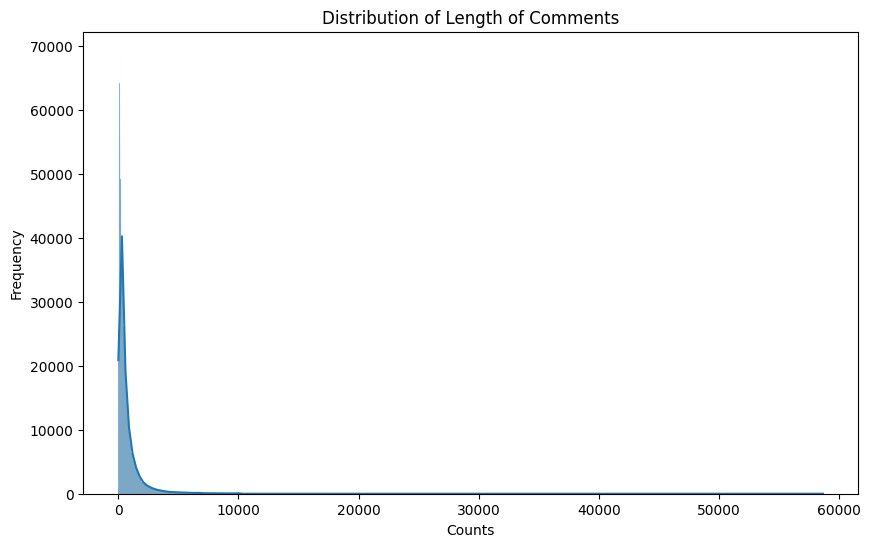

In [18]:
# Plot the histogram of the length of each comment
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
sns.histplot(data=comments, x='len_body', kde=True)

plt.xlabel('Counts')
plt.ylabel('Frequency')
plt.title('Distribution of Length of Comments')

plt.show()

In [ ]:
comments['tokens'] = comments['body'].str.split()

### Other things to try

0. Compare sentiment in data with Hugginface sentiment
1. Create own sentiment analysis model
2. Calculate a new sentiment column using `distilbert-base-uncased-emotion` model that captures emotions

### Comparing sentiment measure using Hugginface pipeline function


In [23]:
test = comments['body'].head(100).str.split()

In [30]:
test

0     [Yeah, but, what, the, above, commenter, is, s...
1     [Any, comparison, of, efficiency, between, sol...
2     [I'm, honestly, waiting, for, climate, change,...
3     [Not, just, Sacramento., It's, actually, happe...
4     [I, think, climate, change, tends, to, get, so...
                            ...                        
95    [Probably, not, too, much., Sindh, Province, h...
96    [I, commuted, by, bike, several, years, during...
97    [My, understanding, is, that, California, has,...
98    [Sounds, like, we, have, 20, years, to, even, ...
99    [🇮🇸, Iceland, would, be, my, choice,, but, I, ...
Name: body, Length: 100, dtype: object

We create a new sentiment column based on `transformers` pipeline function

In [31]:
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
scores = sentiment_pipeline(test)

ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).